# 监督学习 Supervised Learning

引入科学计算和绘图相关包

In [1]:
import logging
from collections import namedtuple

import numpy as np
from pandas import DataFrame
from IPython.display import HTML
from sklearn.linear_model import LinearRegression

# 引入绘图包
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('whitegrid')
logging.basicConfig(level=logging.INFO)
%matplotlib inline

引入波士顿房价数据

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

我们仅使用RM（平均房间数）和Price（按1000美元计的房价中位数）两个指标。

绘制平均房间数和房价中位数的散点图

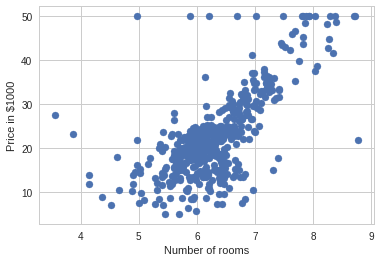

In [3]:
df = DataFrame(data=boston.data, columns=boston.feature_names)[["RM"]].join(DataFrame(data=boston.target, columns=["Price"]))
plt.scatter(df["RM"], df["Price"])
plt.xlabel("Number of rooms")
plt.ylabel("Price in $1000")
plt.show()

为了方便描述，我们这里引入一些符号。$x^{(i)}$ 用来表示输入变量，比如这里的平均房间数，它也被称为**特征features**。$y^{(i)}$ 用来表示输出变量，或我们希望预测的**目标target**变量。一对 $(x^{(i)}, y^{(i)})$ 称为一个**训练样本training example**，而我们将使用的 $m$ 个训练样本 $\{(x^{(i)}, y^{(i)});i=1,...,m\}$ 的集合称为**训练集training set**。注意这里的上标 $(i)$ 是对训练集的一个索引编号，不是幂运算。我们用 $\chi$ 表示输入空间，$\gamma$ 表示输出空间。在这个例子中 $\chi=\gamma=\mathbb{R}$

正式地定义监督学习：给定一个训练集，我们希望学习到一个函数 $h: \chi \rightarrow \gamma$，使得 $h(x)$ 可以很好地预测 $y$。由于历史原因，函数 $h$ 被称为**假设hypothesis**。

当我们希望预测的目标变量是连续型变量时，比如这里的房价，我们称这是一个**回归Regression**问题。当 $y$ 仅仅只取少数离散值时，我们称这是一个**分类Classification**问题。

# 线性回归 Linear Regression

包括以下内容：
    1. 最小二乘法 LMS algorithm
    2. 正规方程 The normal equations
    3. 概率诠释 Probabilistic interpretation
    4. 局部加权线性回归 Locally weighted linear regression

In [4]:
# 预览数据
print(df.head())

      RM  Price
0  6.575   24.0
1  6.421   21.6
2  7.185   34.7
3  6.998   33.4
4  7.147   36.2


对于这个数据集，$x$ 是一个$\mathbb{R}$上的一维向量。$x_1^i$是该区域的平均房间数。

要进行监督学习，我们需要首先决定如何来表示假设/函数 $h$。较为简单的情况下，我们选取 $x$ 的线性函数来预测 $y$ ：
$$ h_\theta(x) = \theta_0 + \theta_1x_1 $$
这里，$\theta_i$称为**参数parameters**（有时也称为**权重weights**），通过这组参数，我们将 $\chi$ 线性映射到 $\gamma$。在不引发误解的情况下，我们将 $h_\theta(x)$简写为 $h(x)$。习惯上，我们设 $x_0=1$ （称为**截距项intercept term**），这样
$$ h(x) = \sum_{i=0}^n \theta_ix_i = \theta^Tx $$
对于右式，我们将 $\theta$ 和 $x$ 看做向量，$n$ 是特征数量（不包括 $x_0$ )

这样，给定训练集，我们需要挑选，或者说学习出参数 $\theta$ 的值。一个直观的方法是使 $h(x)$ 尽量接近 $y$，至少对于训练集来说，尽量地接近。为了更正式地定义“接近”，我们定义**成本函数cost function**：
$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2$$

## 1. 最小二乘法 Linear Regression

我们希望挑选出使 $J(\theta)$ 最小化的值 $\theta$。一种搜索算法的思路是，我们随机猜测一个 $\theta$，然后按某种规则重复地改变 $\theta$ 使得 $J(\theta)$ 不断变小，直到 $\theta$ 收敛到某个值使得 $J(\theta)$ 取得最小值。

特别地，我们将考虑**梯度下降Gradient Descent**算法。如下图所示，$J(\theta)$ 是关于 $\theta_0$ 和 $\theta_1$ 的函数。首先我们随机选择一个 $ \theta = [-10, 17.5]$，想象在图形中下坡，我们需要选择一个下降最快的方向。不断地前进，直到来到某个**局域最小值local minima**。在我们的图中，只有一个**全局最小值global minima**（以红星标记）。但梯度下降的一个特性是，如果存在局域最小值时，根据随机选择初始化 $\theta$ 的不同，我们可能会到达不同的局域最小值。局部最小值的问题，在今后的模型中会遇到。

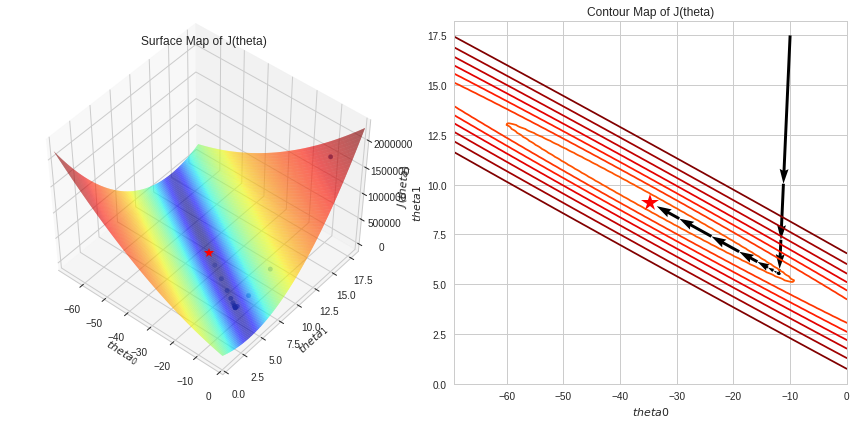

In [5]:
# 读取训练集和目标变量
X, y = df[["RM"]].values, df["Price"].values
m, n = X.shape
# 增加截距列
X_intercept = np.column_stack((np.ones((m, 1)), X))


@np.vectorize
def cost_function(*args):
    """成本函数"""
    theta = np.array(args)
    return 0.5 * ((X_intercept @ theta - y) ** 2).sum()


def gradient_descent_optimize(cost_func, init_theta=None):
    """使用梯度下降寻找最优的theta"""
    alpha = 0.00003

    def good_enough(old_cost, new_cost):
        return np.abs(new_cost - old_cost) / old_cost < 0.00000001

    def improve_theta(old_theta):
        return old_theta - alpha * ((X_intercept @ old_theta - y) @ X_intercept)

    if init_theta is None:
        init_theta = np.array([0, 0])
    path_ = [init_theta]
    o_theta, o_cost = init_theta, cost_function(*init_theta)
    while True:
        n_theta = improve_theta(o_theta)
        n_cost = cost_func(*n_theta)
        path_.append(n_theta)
        logging.debug((o_theta, n_theta, o_cost, n_cost))
        if good_enough(o_cost, n_cost):
            break
        o_theta, o_cost = n_theta, n_cost
    Result = namedtuple('Result', ['theta', 'path'])
    return Result(theta=n_theta, path=np.array(path_))

# 使用梯度下降获取优化结果
init_guess = np.array([-10, 17.5])
gradient_descent_result = gradient_descent_optimize(cost_function, init_theta=init_guess)
path = gradient_descent_result.path
sampled_path = np.concatenate((np.array([path[0, ]]),
                               path[(2 ** np.array(range(int(np.ceil(np.log2(path.shape[0])))))).astype(np.int32), ]))
sampled_path_mat = sampled_path.T

# 使用sklearn的LinearRegression模型，直接获取最终的theta值
regr = LinearRegression()
regr.fit(X, y)
theta0_optimize, theta1_optimize = regr.intercept_, regr.coef_[0]
minima = np.array([theta0_optimize, theta1_optimize])
minima_ = minima.reshape(-1, 1)

# 根据最优化的theta，生成以此为中心的网格数据
step = 0.2
theta0_min, theta0_max = theta0_optimize - np.abs(theta0_optimize), theta0_optimize + np.abs(theta0_optimize)
theta1_min, theta1_max = theta1_optimize - np.abs(theta1_optimize), theta1_optimize + np.abs(theta1_optimize)
theta0_range, theta1_range = np.arange(theta0_min, theta0_max + step, step), np.arange(
    theta1_min, theta1_max + step, step)
theta0_mat, theta1_mat = np.meshgrid(theta0_range, theta1_range)
z = cost_function(theta0_mat.reshape(-1), theta1_mat.reshape(-1)).reshape(theta0_mat.shape)

fig = plt.figure(figsize=(12, 6))
# 绘制surface平面图
ax1 = fig.add_subplot(1, 2, 1, projection='3d', elev=50, azim=-50)
ax1.plot_surface(theta0_mat, theta1_mat, z, norm=LogNorm(), cmap=cm.jet, rstride=1, cstride=1, edgecolor='none',
                 alpha=.8)
ax1.scatter(sampled_path_mat[0, :-1], sampled_path_mat[1, :-1], cost_function(*sampled_path_mat[::, :-1]))
ax1.plot(*minima_, cost_function(*minima_), 'r*', markersize=10)
ax1.set_xlabel('$theta_0$')
ax1.set_ylabel('$theta_1$')
ax1.set_zlabel('$J(theta)$')
ax1.set_xlim((theta0_min, theta0_max))
ax1.set_ylim((theta1_min, theta1_max))
ax1.set_title("Surface Map of J(theta)")

# 绘制contour轮廓图
ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(theta0_mat, theta1_mat, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=cm.jet)
ax2.plot(*minima_, 'r*', markersize=18)
ax2.quiver(sampled_path_mat[0, :-1], sampled_path_mat[1, :-1], sampled_path_mat[0, 1:] - sampled_path_mat[0, :-1],
           sampled_path_mat[1, 1:] - sampled_path_mat[1, :-1],
           scale_units='xy', angles='xy', scale=1, color='k')
ax2.set_xlabel('$theta0$')
ax2.set_ylabel('$theta1$')
ax2.set_xlim((theta0_min, theta0_max))
ax2.set_ylim((theta1_min, theta1_max))
ax2.set_title("Contour Map of J(theta)")

plt.tight_layout()
plt.show()

下面以数学形式定义梯度下降，随机选择某个初始 $\theta$，之后重复以下更新：
$$ \theta_j = \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta) $$
（同时对所有值进行更新，$j = 0,...,n$）

这里，$\alpha$ 称为**学习速率learning rate**。这个算法非常自然地每次往J下降幅度最为陡峭的方向前进一小步。当 $\alpha$ 过小时，算法的收敛速度会比较慢；而 $\alpha$ 过大时，会出现算法不收敛的情况。另外，梯度下降过程中，梯度 $\frac{\partial}{\partial\theta_j}J(\theta)$ 本身会不断变小，因此更新的幅度也会越来越小：

$$\begin{equation}
\begin{split}
\frac{\partial}{\partial\theta_j}J(\theta) & = \sum_{i=1}^m\frac{\partial}{\partial\theta_j}\frac{1}{2}(h_\theta(x^{(i)}) - y^{(i)})^2 \\
 & = \sum_{i=1}^m2 \cdot \frac{1}{2}(h_\theta(x^{(i)}) - y^{(i)}) \cdot \frac{\partial}{\partial\theta_j}(h_\theta(x^{(i)}) - y^{(i)}) \\
 & = \sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)}) \cdot \frac{\partial}{\partial\theta_j}(\sum_{k=0}^{n}\theta_kx_k^{(i)}-y^{(i)}) \\
 & = \sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
\end{split}
\end{equation}$$

我们根据以下规则进行更新：
$$ \theta_j = \theta_j - \alpha\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} $$
重复直至 $\theta$ 收敛即可。

这个规则称为**最小二乘 LMS least mean square**，也被称为**Widrow-Hoff学习规则**。

每次更新过程中都检查整个训练集，我们称这种算法为**批量梯度下降 batch gradient descent**。对于线性回归来说，成本函数只有唯一一个全局最小值，不存在局域最小值。也就是说，$J$ 是一个凸二次函数。梯度下降对于线性回归总能收敛（唯一的前提，学习速率 $\alpha$ 没有选得过大）。

下图展现了动画形式的梯度下降训练过程：

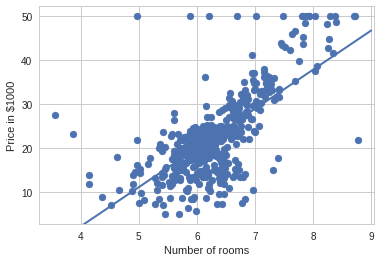

In [6]:
fig, ax = plt.subplots()
ax.scatter(X.reshape(-1), y)
plt.xlabel("Number of rooms")
plt.ylabel("Price in $1000")
x = np.arange(3, 10, 1)
line, = ax.plot([], [], lw=2)


def animate(i):
    line.set_data(x, np.column_stack((np.ones((x.size, 1)), x)) @ sampled_path[i])
    return line,


def init():
    line.set_data([], [])
    return line,


anim = animation.FuncAnimation(fig, animate, frames=sampled_path.shape[0], init_func=init, interval=800, 
                               repeat_delay=3000, blit=True)

HTML(anim.to_html5_video())

In [7]:
# 使用批量梯度下降训练出的theta
print(gradient_descent_result.theta)

[-34.35932859   9.05317227]


In [8]:
# 使用sklearn的LinearRegression模型训练出的theta
print(minima)

[-34.67062078   9.10210898]


可以看出，梯度下降训练出的 $\theta$ 十分接近使用高级优化算法计算出的最优 $\theta$；进一步增加good_enough函数中的精度，可以使梯度下降算法训练出更精确的 $\theta$（同时也需要花费更多的迭代次数，意味着更长的训练时间）。

批量梯度下降的执行效率较低，因为每一次迭代更新，都需要使用全量数据来计算梯度。当 $m$ 非常大的时候，这个操作十分耗时。考虑另一种效果同样不错，但是效率更高的替代方案：
$$ \theta_j = \theta_j - \alpha(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} $$
对于 $i = 1, 2, ..., m$ 重复执行，每次执行同时对所有值进行更新，$j = 0,...,n$

在该算法中，我们遍历整个训练集，对每一个训练样本，仅以该样本的梯度进行参数更新。这种算法叫做**随机梯度下降 stochastic gradient descent**，也称为**增量梯度下降 incremental gradient descent**。

随机梯度下降通常会比批量梯度下降更快地接近最优 $\theta$，但需要注意的是，随机梯度下降可能永远不会“收敛”到最小值，其训练的参数 $ \theta $会在 $J(\theta)$ 取得最小值处震荡。但是在实际情况中，最小值附近的值就已经足够好了。由于这些原因，当训练集非常大时，我们通常更趋向于使用随机梯度下降。


## 2. 正规方程 The normal equations

梯度下降是一种迭代算法，从算法描述就可以看出它非常符合计算机科学的思维方式。而正规方程是一种直接求最小值的方法，我们令 $J(\theta)$ 的导数为0，进一步通过推导的形式计算出此时的 $\theta$，显然这是数学的思维方式。

### 2.1 矩阵导数 Matrix derivatives

对于一个将 $m \times n$ 矩阵映射到实数的函数 $f: \mathbb{R}^{m \times n} \rightarrow \mathbb{R} $，我们定义 $f$ 对 $A$ 的导数为：

$$
\nabla_Af(A) = 
\begin{bmatrix}
    \frac{\partial f}{\partial A_{11}} & \dots & \frac{\partial f}{\partial A_{1n}} \\
    \vdots & \ddots & \vdots \\
    \frac{\partial f}{\partial A_{m1}} & \dots & \frac{\partial f}{\partial A_{mn}}
\end{bmatrix}
$$

因此，梯度 $\nabla_Af(A)$ 本身是一个 $m \times n$ 的矩阵，其第 $(i, j)$ 个元素为 $\frac{\partial f}{\partial A_{ij}}$。

以一个 $2 \times 2$ 的矩阵为例，假设 $f(A) = \frac{3}{2}A_{11} + 5A_{12}^2 + A_{21}A_{22}$，那么：
$$
\nabla_Af(A) = 
\begin{bmatrix}
    \frac{\partial f}{\partial A_{11}} & \frac{\partial f}{\partial A_{12}} \\
    \frac{\partial f}{\partial A_{21}} & \frac{\partial f}{\partial A_{22}}
\end{bmatrix} = 
\begin{bmatrix}
    \frac{3}{2} & 10A_{12} \\
    A_{22} & A_{21}
\end{bmatrix}
$$

对于一个 $n \times n$ 的矩阵（方阵）A，矩阵的**迹 trace**，记做 $trA$，定义为对角线上的元素之和：
$$ trA = \sum_{i=1}^n A_{ii} $$

如果 $a$ 是一个实数（$ 1 \times 1$ 矩阵），$tr a = a$

对于矩阵 $A$ 和矩阵 $B$，如果矩阵 $AB$ 是方阵，那么 $trAB = trBA$。证明如下：

设 $A$ 是一个 $ m \times n$ 的矩阵，为了使 $AB$ 是方阵，则 $B$ 必须是 $n \times m$的矩阵，根据矩阵相乘和迹的定义
$$ trAB =  \sum_{i=1}^m(\sum_{j=1}^n A_{ij}B_{ji}) = \sum_{j=1}^n(\sum_{i=1}^m B_{ji}A_{ij}) = trBA$$

显然上述结论具有以下推论：
$$ trABC = trCAB = trBCA $$
$$ trABCD = trDABC = tr CDAB = tr BCDA$$

对于方阵 $A$，方阵 $B$ 和实数a：
$$ trA = trA^T $$
$$ tr(A + B) = trA + trB $$
$$ traA = atrA $$

矩阵的导数具有以下性质：
$$
\begin{align*}
\nabla_AtrAB &= B^T  &(1) \\
\nabla_{A^T}f(A) &= (\nabla_Af(A))^T &(2) \\
\nabla_A trABA^TC &= CAB + C^TAB^T &(3) \\
\nabla_A |A| &= |A|(A^{-1})^T &(4)
\end{align*}
$$

依然沿用 $A$ 是 $m \times n$ 的矩阵，$B$ 是 $n \times m$的矩阵的假设，证明如下：

1) 设 $ f(A) = trAB$，显然 $f$ 满足条件 $\mathbb{R}^{m \times n} \rightarrow \mathbb{R}$的映射
$$ \nabla_AtrAB = \nabla_Af(A) = \nabla_A \sum_{i=1}^m\sum_{j=1}^nA_{ij}B_{ji} =
\begin{bmatrix}
    B_{11} & \dots & B_{n1} \\
    \vdots & \ddots & \vdots \\
    B_{1m} & \dots & B_{nm}
\end{bmatrix}
= B^T
$$

2) 设 $ X = A^T $，即 $X_{ji} = A_{ij}$:
$$
\begin{equation}
\begin{split}
\nabla_{A^T}f(A) & = \nabla_{A^T}f(A_{11}, ..., A_{1n}, A_{21}, ..., A_{2n},..., A_{m1}, ..., A_{mn}) \\
& = \nabla_{X}f(X_{11}, ..., X_{n1}, X_{12}, ..., X_{n2},..., X_{1m}, ..., X_{nm}) \\
& = \nabla_{X}f(X_{11}, ..., X_{1m}, X_{21}, ..., X_{2n},..., X_{1n}, ..., X_{nm}) \\
& = \begin{bmatrix}
    \frac{\partial f}{\partial X_{11}} & \dots & \frac{\partial f}{\partial X_{1m}} \\
    \vdots & \ddots & \vdots \\
    \frac{\partial f}{\partial X_{n1}} & \dots & \frac{\partial f}{\partial X_{nm}}
\end{bmatrix} \\
& = \begin{bmatrix}
    \frac{\partial f}{\partial X_{11}} & \dots & \frac{\partial f}{\partial X_{n1}} \\
    \vdots & \ddots & \vdots \\
    \frac{\partial f}{\partial X_{1m}} & \dots & \frac{\partial f}{\partial X_{nm}}
\end{bmatrix}^T \\
& = \begin{bmatrix}
    \frac{\partial f}{\partial A_{11}} & \dots & \frac{\partial f}{\partial A_{1n}} \\
    \vdots & \ddots & \vdots \\
    \frac{\partial f}{\partial A_{m1}} & \dots & \frac{\partial f}{\partial A_{mn}}
\end{bmatrix}^T \\
& = (\nabla_{A}f(A))^T
\end{split}
\end{equation}
$$

3) 略

4) 略



### 2.2 最小二乘法回顾 Least squares revisited

将整个训练集想象成一个 $m \times n$ 的矩阵（如果加入截距项的话，实际是 $m \times n+1$ 的矩阵），$y$ 想象成是 $m$ 维的向量，$h_\theta(x) = X \theta$。于是，成本函数可以表示为：
$$
J(\theta) = \frac{1}{2}\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 = \frac{1}{2}(X\theta-y)^T(X\theta-y)
$$

其导数可以表示为：
$$
\begin{split}
\nabla_{\theta}J(\theta) & = \nabla_{\theta}\frac{1}{2}(X\theta-y)^T(X\theta-y) \\
& = \frac{1}{2}\nabla_{\theta}(\theta^TX^TX\theta - \theta^TX^Ty - y^TX\theta + y^Ty) \\
& = \frac{1}{2}\nabla_{\theta}tr(\theta^TX^TX\theta - \theta^TX^Ty - y^TX\theta + y^Ty) \\
& = \frac{1}{2}\nabla_{\theta}(tr\theta^TX^TX\theta - 2try^TX\theta) \\
& = \frac{1}{2}(X^TX\theta + X^TX\theta - 2X^Ty) \\
& = X^TX\theta - X^Ty
\end{split}
$$

上述推导过程中，第二步是矩阵相乘；第三步利用了实数的迹等于实数本身；第四步利用了 $trA = trA^T$，而 $y^Ty$ 与 $\theta$ 无关；第五步首先利用了公式 $\nabla_AtrA^TCAB = \nabla_A trABA^TC = CAB + C^TAB^T$，令 $A=\theta, C=X^TX, B=I$。其次利用了 $\nabla_AtrBA = \nabla_AtrAB = B^T$。

为了使 $J(\theta)$ 最小化，我们将其导数设为零，于是得到正规方程：
$$ X^TX\theta = X^Ty $$

所以，使 $J(\theta)$ 取得最小值的 $\theta$ 为：
$$ \theta = (X^TX)^{-1}X^Ty $$